In [1]:
# Importando Librerias

import pandas as pd
import os, string, unicodedata, re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.util import ngrams
import nltk
from tensorflow.keras.utils import to_categorical
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import random
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns


In [2]:
random.seed(32)
np.random.seed(32)



#

# **1. RECLASIFICANDO df_csv con df_clasificador**

## **1.1 Leyendo los archivos**

In [ ]:
df_csv =  pd.read_csv('data/informacion_roles_actualizado.csv')

df_clasificador = pd.read_excel('data/CLASIFICADO_FINAL.xlsx')

- `df_csv`: Contiene los datos que tenemos que reclasificar con el dataframe df_clasificador
- `df_clasificador` corresponde al df donde se encuentran las etiquetas bien clasificadas

In [4]:
df_csv.head()

,rol,corte,fecha,folio,tramite,descripcion,fecha_ingreso
0,144280-2022,Valparaíso,05/02/2024,26.0,Actuación,COMUNICA CÚMPLASE CS,31/10/2022
1,144280-2022,Valparaíso,05/02/2024,25.0,Actuación,COMUNICA CÚMPLASE CS,31/10/2022
2,144280-2022,Valparaíso,05/02/2024,24.0,Resolución,Cúmplase CS,31/10/2022
3,144280-2022,Valparaíso,05/12/2023,23.0,Escrito,Recurso fallado Corte Suprema,31/10/2022
4,144280-2022,Valparaíso,15/06/2023,22.0,Resolución,(NMV)Concede Recurso (Intercon,31/10/2022


In [5]:
df_clasificador.head()

,Unnamed: 0,Descripcion,CLASIFICACION_FINAL
0,1461,Cumple lo ordenado / En Relaci,Téngase presente
1,202,Rec.Prot/D.cta.ONI.Sala Isapre,Dese cuenta
2,200,Cumple previo/Admisible GES,Admisibles
3,2621,Cambio código a masivo,ICA informa
4,1095,ocúrrase donde corresonda,ICA informa


## **1.2 Tratando los dfs**

In [6]:
df_clasificador['CLASIFICACION_FINAL'] = df_clasificador['CLASIFICACION_FINAL'].str.title()

In [7]:
df_clasificador['CLASIFICACION_FINAL'].value_counts()



CLASIFICACION_FINAL
Ica Solicita Diligencia    379
Agréguese A Tabla          319
Ica Informa                291
Evacua Informe             285
Admisibles                 255
Téngase Presente           203
Dese Cuenta                164
Apercibe                   160
Ica Amplia Plazo           138
Nhl                        119
Acoge                       69
Concede Apelación           54
Acuerdo                     43
Certifiquese                39
Cs                          38
Rechazada                   31
Art / Numeral               25
Archivado                   24
Fija Costas                 22
Inhabilidad                 22
Acumulación                 19
Oni                         17
Prescinde                   13
Inadmisible/Omite           13
Incompetencia               12
Multa                        7
Fallo/Desestima              5
Retira                       4
Inicio Tramitación           4
Name: count, dtype: int64

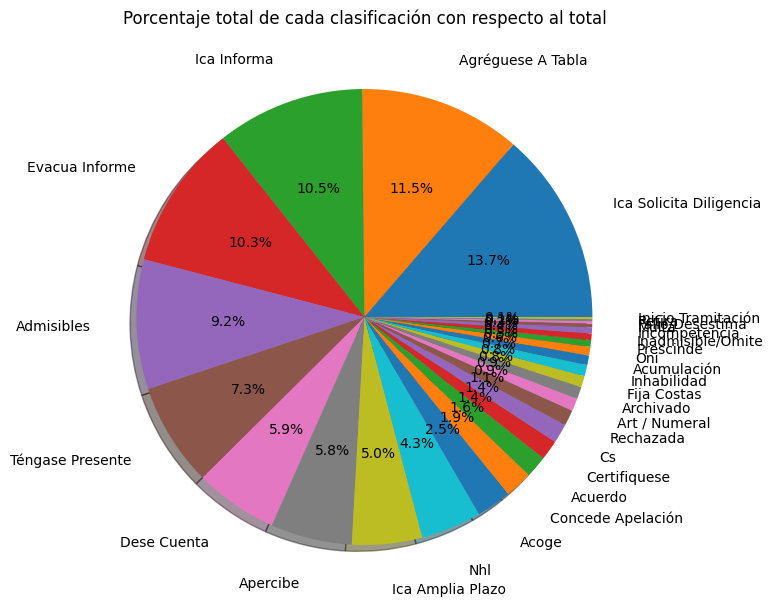

In [8]:
plt.figure(figsize=(10, 6))
plt.pie(df_clasificador['CLASIFICACION_FINAL'].value_counts(), labels=df_clasificador['CLASIFICACION_FINAL'].value_counts().index, autopct='%1.1f%%', labeldistance=1.2, normalize=True, shadow=True)
plt.tight_layout()
plt.title('Porcentaje total de cada clasificación con respecto al total')
plt.show()

- Tenemos bastante categorias que están muy poco presentes como es notorio en nuestro gráfico.
- Esto puede ser un problema considerando el desbalance de clases

### Generar el diccionario para CLASIFICACION FINAL - Descripción

In [9]:
# Genera un diccionario key = la clasificación correcta , value = todas los textos clasificados con esa etiqueta
dict_to_replace = df_clasificador.groupby('CLASIFICACION_FINAL')['Descripcion'].apply(list).to_dict()

- Cada descripción del dataframe se asocia a una respectiva categoria. Con esto podremos recategorizar el dataframe `df_csv`

In [10]:
# Función para reemplazar los datos
def mapear_valor(descripcion: str, diccionario: dict) -> str:

    """
    Toma un diccionario y ve si el valor está en en una cadena de texto. En caso de que esté devuelve la key del diccionario
    en caso de no encontrar concidencia entonces retorna el texto original
    """
    for key, values in diccionario.items():
        for value in values:
            if str(value).lower() in descripcion.lower():
                return key
    return descripcion 


### **CLASIFICANDO LOS VALORES DE df_csv con los valores de df_clasificador**

In [11]:
# Generando una nueva columna en el df que no se encuentra clasificado correctamente reempalzando sus valores según el diccionario clasificador
df_csv['CLASIFICACION_CORRECTA']=df_csv.loc[(df_csv['tramite']=='Resolución') | (df_csv['tramite']=='Sentencia'), :]['descripcion'].apply(lambda x: mapear_valor(x, dict_to_replace))

### **Solo dejando los registros en los cuales el trámite sea resolución o Sentencia**

In [12]:
df_csv = df_csv.loc[(df_csv['tramite']=='Resolución') | (df_csv['tramite']=='Sentencia'), :]

- Debido que en este problema solo nos interesa aquellos trámites que sean o Resolución o Sentencia, solo estos tipos de trámites son incluidos ya que las demás opciones son datos que no nos aportan ningun detalle a nuestro intento de predicciones

# **PROCESADO DEL TEXTO**

In [13]:
df_csv['dup_count'] = df_csv.groupby(['descripcion', 'CLASIFICACION_CORRECTA']).cumcount() + 1
max_veces = 3  

df_csv= df_csv[df_csv['dup_count'] <= max_veces]

In [14]:
# Obteniendo la lista de oraciones
sentences =  [ line for line in df_csv['descripcion'].values if line != 'Unknown']

In [15]:
sentences[:10]

['Cúmplase CS',
 '(NMV)Concede Recurso (Intercon',
 'NMV7/Acogida',
 'Agréguese Extraordinariamente',
 '7NMV/Estese al mérito',
 'nmv 3.Téngase Presente',
 '(8) Pide informe ONI',
 '(7)Estese al mérito de autos',
 '(5). Por Evacuado Informe, en',
 '(4)Interpuesto Recurso de Prot']

In [16]:
# Función para limpiar los textos
def cleaning_data(text):
    # Eliminar caracteres de puntuación
    text = text.replace('(', ' ').replace(')', ' ')
    text = text.replace('/', ' ').replace(')', ' ')

    clean_txt = "".join(char for char in text if char not in string.punctuation)
    
    # Normalizar el texto a ASCII
    text_normalized = unicodedata.normalize('NFKD', clean_txt).encode('ascii', 'ignore').decode('ascii')
    
    # Eliminar espacios adicionales y convertir a minúsculas
    text_cleaned = re.sub(r'\s{2,}', ' ', text_normalized).strip().lower()
    
    # Eliminar dígitos y palabras específicas (si no son útiles)
    text_cleaned = re.sub(r'^(\d+)\s|\d+(?=[a-zA-Z])', '', text_cleaned)  # Elimina números
    text_cleaned = re.sub(r'nmv', '', text_cleaned).strip()  # Elimina "nmv"
    
    return text_cleaned


In [17]:
# Oraciones limpias
clean_data = [cleaning_data(t) for t in sentences]

In [18]:
clean_data[:10]

['cumplase cs',
 'concede recurso intercon',
 '7 acogida',
 'agreguese extraordinariamente',
 'estese al merito',
 'tengase presente',
 'pide informe oni',
 'estese al merito de autos',
 'por evacuado informe en',
 'interpuesto recurso de prot']

## Eliminando las stopwords

In [19]:
import nltk
from nltk.corpus import stopwords

# Descargar las stopwords si no lo has hecho antes
nltk.download('stopwords')

# Obtener las stopwords en español
stop_words_es = set(stopwords.words('spanish'))

print(stop_words_es)

{'tuviésemos', 'habidos', 'tiene', 'mía', 'habíais', 'para', 'los', 'mí', 'tuyas', 'hemos', 'fue', 'todos', 'tuvieses', 'hubo', 'habida', 'hubieses', 'serían', 'has', 'lo', 'hubiese', 'estadas', 'éramos', 'habréis', 'tuviste', 'quienes', 'tendréis', 'a', 'tengas', 'tuviéramos', 'tened', 'eres', 'sí', 'estarán', 'teníais', 'son', 'estuvisteis', 'otros', 'hubiesen', 'fui', 'algo', 'tuvo', 'poco', 'erais', 'tuvierais', 'de', 'hubisteis', 'te', 'en', 'hayamos', 'habría', 'hayáis', 'tenidas', 'que', 'sea', 'estábamos', 'vuestro', 'ha', 'habían', 'estuvieras', 'estés', 'habrían', 'esos', 'tenéis', 'tendrían', 'se', 'sean', 'estado', 'tus', 'habríais', 'será', 'estaríais', 'estás', 'tengamos', 'habrás', 'fuerais', 'tienen', 'tuvieras', 'habremos', 'tuvieseis', 'estuvimos', 'tengan', 'tanto', 'ti', 'seáis', 'eso', 'estarás', 'han', 'hasta', 'como', 'suya', 'serán', 'tendremos', 'sobre', 'tuvisteis', 'sentido', 'un', 'más', 'fueran', 'estos', 'hubieras', 'estaríamos', 'sentida', 'o', 'habrán', 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kev_g\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:

clean_data = [word for word in clean_data if word not in stop_words_es]

## TOKENIZACIÓN

In [21]:

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words= 2300, oov_token="<OOV>")

In [22]:
tokenizer.fit_on_texts(clean_data)

# Al vocabulario total que tenemos le sumamos 1 para asegurarnos que incluya el indice 0 del pading (tokenizer.word_index = dict)
total_words = len(tokenizer.word_index) + 1 

sequences = tokenizer.texts_to_sequences(clean_data)

max_sequence_len = max([len(x) for x in sequences])



In [23]:
df_csv['CLASIFICACION_CORRECTA'].value_counts()

CLASIFICACION_CORRECTA
Agréguese A Tabla          699
Admisibles                 531
Evacua Informe             523
Ica Informa                457
Ica Solicita Diligencia    453
Dese Cuenta                303
Ica Amplia Plazo           300
Apercibe                   235
Téngase Presente           202
Nhl                        138
Acoge                      137
Concede Apelación          125
Cs                          86
Certifiquese                69
Acuerdo                     64
Archivado                   59
Art / Numeral               46
Fija Costas                 45
Rechazada                   44
Acumulación                 34
Oni                         23
Inadmisible/Omite           22
Inhabilidad                 20
Incompetencia               20
Prescinde                   17
Fallo/Desestima             10
Retira                       8
Multa                        6
Inicio Tramitación           5
Name: count, dtype: int64

- Existe un **desbalanceo de clases evidente**. Además hay clases que tiene muy pocos ejemplos. En consideración de la disponibilidad de datos y el conocimiento profundo de los datos que tengo realizaré un data augmentation que quedará en la carpeta
`data_augmentation`

In [24]:
from sklearn.preprocessing import LabelEncoder

# 1. Convertir etiquetas de texto a números
label_encoder = LabelEncoder()
df_csv['CLASIFICACION_NUM'] = label_encoder.fit_transform(df_csv['CLASIFICACION_CORRECTA'])


# 2. Convertir etiquetas numéricas a one-hot encoding
y_categorical = to_categorical(df_csv['CLASIFICACION_NUM'])

In [25]:
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_len, padding='pre')

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y_categorical, test_size=0.3, random_state=42)



## **3. DATA AUGMENTATION**

In [26]:
from data_augmentation.main import main
df_augmented = main()
df_augmented.head()



,frase,etiqueta
0,(PB)NHL/pide cuenta(IH),Ica Solicita Diligencia
1,Concedida la apelacion de la parte Recurrente,Concede Apelación
2,"Inicio tramitación, del solicitud.",Inicio Tramitación
3,previene cumplimiento,Ica Informa
4,La comisión de falta de seguridad laboral se m...,Multa


In [27]:
df_augmented.columns=['descripcion', 'CLASIFICACION_CORRECTA']

In [28]:
df_augmented['CLASIFICACION_CORRECTA'].value_counts()

CLASIFICACION_CORRECTA
Fija Costas                299
Inadmisible/Omite          291
Retira                     275
Archivado                  275
Acumulación                270
Prescinde                  260
Inhabilidad                260
Rechazada                  260
Nhl                        253
Multa                      234
Acoge                      231
Cs                         213
Certifiquese               209
Ica Solicita Diligencia    200
Dese Cuenta                198
Concede Apelación          185
Art / Numeral              183
Apercibe                   180
Incompetencia              173
Ica Informa                170
Téngase Presente           165
Oni                        138
Inicio Tramitación         135
Fallo/Desestima            108
Acuerdo                    104
Agréguese A Tabla          100
Evacua Informe             100
Admisibles                  30
Ica Amplia Plazo            25
Name: count, dtype: int64

In [29]:
df_csv2 = df_csv.copy()

In [30]:


# Añadir las nuevas filas al DataFrame existente
df = pd.concat([df_csv2, df_augmented], ignore_index=True)

# Mostrar los últimos registros para verificar
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df

,rol,corte,fecha,folio,tramite,descripcion,fecha_ingreso,CLASIFICACION_CORRECTA,dup_count,CLASIFICACION_NUM
0,NaN,NaN,NaN,NaN,NaN,La corte inadmis. la recurso desistimiento,NaN,Inadmisible/Omite,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,cúmplase/revocada si costas .,NaN,Cs,NaN,NaN
2,151768-2022,Santiago,26/01/2023,9.0,Resolución,En Relación GES,29/11/2022,Evacua Informe,3.0,12.0
3,16144-2018,Santiago,14/06/2018,9.0,Resolución,EN RELACION,21/12/2018,Evacua Informe,1.0,12.0
4,NaN,NaN,NaN,NaN,NaN,El apelación se rechazaa con costas repartidas...,NaN,Rechazada,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
10200,NaN,NaN,NaN,NaN,NaN,Debido a incumplimiento de cobertura por parte...,NaN,Rechazada,NaN,NaN
10201,NaN,NaN,NaN,NaN,NaN,(NC)evinf(GV,NaN,Evacua Informe,NaN,NaN
10202,NaN,NaN,NaN,NaN,NaN,Prescinde de la Terc. por no cumplir con la or...,NaN,Prescinde,NaN,NaN
10203,13365-2023,Temuco,19/03/2024,12.0,Sentencia,"Acogida con costas, 50.000",13/09/2023,Acoge,1.0,0.0


In [31]:
total_clases_after = len(df['CLASIFICACION_CORRECTA'].unique())
print(f'Total de clases: {total_clases_after}')

Total de clases: 29


In [32]:
df['CLASIFICACION_CORRECTA'].unique()

array(['Inadmisible/Omite', 'Cs', 'Evacua Informe', 'Rechazada',
       'Apercibe', 'Agréguese A Tabla', 'Dese Cuenta', 'Admisibles',
       'Oni', 'Fija Costas', 'Archivado', 'Certifiquese', 'Art / Numeral',
       'Concede Apelación', 'Acuerdo', 'Ica Informa', 'Inhabilidad',
       'Multa', 'Nhl', 'Ica Solicita Diligencia', 'Acoge',
       'Incompetencia', 'Prescinde', 'Ica Amplia Plazo',
       'Téngase Presente', 'Retira', 'Fallo/Desestima',
       'Inicio Tramitación', 'Acumulación'], dtype=object)

In [33]:
df = df.drop_duplicates(subset=['descripcion', 'CLASIFICACION_CORRECTA'])


In [34]:
df.shape

(8159, 10)

In [35]:
sentences =  [ line for line in df['descripcion'].values if line != 'Unknown']
clean_data = [cleaning_data(t) for t in sentences]


In [36]:
clean_data = [
    ' '.join([word for word in sentence.split() if word.lower() not in stop_words_es])
    for sentence in clean_data
]

# Imprimir el resultado
clean_data[:10]

['corte inadmis recurso desistimiento',
 'cumplase revocada si costas',
 'relacion ges',
 'relacion',
 'apelacion rechazaa costas repartidas carecer interes legitimo',
 'notifica apercb parte cumplir ordenado',
 'folio 74 cs revoca',
 'agreguese extraordinariamente tabla 14 agosto er ev inf masvida',
 'f 14 dcuenta sala respectiva',
 'nc acoge tramitacion pbd']

In [37]:
with open('clean_data.txt', 'w') as f:
    for sentence in clean_data:
        f.write(sentence + '\n')  # Escribir cada oración seguida de un salto de línea

In [38]:
with open('clean_data.txt', 'r', encoding='utf-8') as f:
    loaded_data = f.readlines()

# Eliminar los saltos de línea (\n) al final de cada oración
clean_data = [line.strip() for line in loaded_data]

clean_data

['corte inadmis recurso desistimiento',
 'cumplase revocada si costas',
 'relacion ges',
 'relacion',
 'apelacion rechazaa costas repartidas carecer interes legitimo',
 'notifica apercb parte cumplir ordenado',
 'folio 74 cs revoca',
 'agreguese extraordinariamente tabla 14 agosto er ev inf masvida',
 'f 14 dcuenta sala respectiva',
 'nc acoge tramitacion pbd',
 'agreguese extraordinariamente tabla 13 mayo',
 'corte valdivia aceptada onia resolucion folio 17 aceptada oni',
 'corte apelaciones ccp fija precios 7 unidades',
 'agreguese extraordinariamente tabla 09 julio',
 'falta informacion proporcionada isapre solicitud archivo',
 'plan complementario cert duplicidad pbd',
 'transcurrido plazo 77 dias dese estricto cumplimiento articulo 125',
 'vista consideracion informado ca ca concedase recurso vista',
 'nota acuerdo redaccion catalina soto',
 'previene cumplimiento',
 'inhabilidad ministro munoz torres',
 'corte apelaciones stgo fija tarifas 200000 unidades',
 'falta seguridad labo

In [39]:

unique_words = set(word for sentence in clean_data for word in sentence.split())
total_words = len(unique_words) + 1 # Total de palabras

print(f'Las palabras unicas son: {total_words}')

Las palabras unicas son: 3540


In [40]:

# 1. Convertir etiquetas de texto a números
label_encoder = LabelEncoder()
df['CLASIFICACION_NUM'] = label_encoder.fit_transform(df['CLASIFICACION_CORRECTA'])


# 2. Convertir etiquetas numéricas a one-hot encoding
y_categorical = to_categorical(df['CLASIFICACION_NUM'])


C:\Users\kev_g\AppData\Local\Temp\ipykernel_25904\2690493204.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CLASIFICACION_NUM'] = label_encoder.fit_transform(df['CLASIFICACION_CORRECTA'])


In [41]:
# Tokenización
tokenizer = Tokenizer(num_words=total_words, oov_token="<OOV>")#2619



tokenizer.fit_on_texts(clean_data)

# Al vocabulario total que tenemos le sumamos 1 para asegurarnos que incluya el indice 0 del pading (tokenizer.word_index = dict)
total_words = len(tokenizer.word_index) + 1 

sequences = tokenizer.texts_to_sequences(clean_data)

max_sequence_len = max([len(x) for x in sequences])



In [42]:
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_len, padding='pre')
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y_categorical, test_size=0.2, random_state=42,  stratify=df['CLASIFICACION_NUM'])

In [43]:
from sklearn.metrics import classification_report, confusion_matrix

def metricas_clases(X_test, y_test ,model):

    """
    Función que genera probabilidades para el conjunto de prueba y las combierte a las clases predichas. También genera informe de clasificación y matriz de confusion.
    return: Retorna un dataframe con el clasification report.
    """
    # Predecir las probabilidades para el conjunto de prueba
    y_pred_probs = model.predict(X_test)

    # Convertir las probabilidades a clases predichas
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Obtener las etiquetas reales
    y_true = np.argmax(y_test, axis=1)

    # Generar el informe de clasificación
    print("Informe de clasificación:")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
    
    classification_report_dict = classification_report(y_true, y_pred,  labels=np.arange(28)
        ,target_names=label_encoder.classes_, output_dict=True)

    df_cr = pd.DataFrame(classification_report_dict).transpose()

    # Generar la matriz de confusión
    cm = confusion_matrix(y_true, y_pred)

    # Visualizar la matriz de confusión
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.ylabel('Etiqueta Real')
    plt.xlabel('Etiqueta Predicha')
    plt.title('Matriz de Confusión')
    plt.show()

    return df_cr

# **MODELAJE**

In [44]:
# Definición del modelo
model = Sequential()

# Capa de Embedding
model.add(Embedding(input_dim=total_words, output_dim=124, input_length=max_sequence_len))

# Capa LSTM
model.add(LSTM(256, return_sequences=False, kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.5))

# Capa densa
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.4))

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.3))

# Capa de salida
model.add(Dense(y_categorical.shape[1], activation='softmax'))

# Compilación del modelo
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)





c:\DEEP_LEARNING\Project_1\myenv\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [45]:
history2 = model.fit(
    X_train, 
    y_train,
    epochs=10, 
    batch_size=32, 
    validation_data = (X_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 19s 82ms/step - accuracy: 0.0712 - loss: 3.2631 - val_accuracy: 0.4975 - val_loss: 1.7660 - learning_rate: 0.0010
Epoch 2/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 17s 81ms/step - accuracy: 0.4866 - loss: 1.6481 - val_accuracy: 0.8309 - val_loss: 0.6640 - learning_rate: 0.0010
Epoch 3/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 17s 82ms/step - accuracy: 0.7334 - loss: 0.9147 - val_accuracy: 0.8977 - val_loss: 0.4399 - learning_rate: 0.0010
Epoch 4/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 17s 81ms/step - accuracy: 0.8539 - loss: 0.5484 - val_accuracy: 0.9375 - val_loss: 0.3517 - learning_rate: 0.0010
Epoch 5/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 17s 81ms/step - accuracy: 0.9008 - loss: 0.4112 - val_accuracy: 0.9320 - val_loss: 0.3631 - learning_rate: 0.0010
Epoch 6/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - accuracy: 0.9190 - loss: 0.3462 - val_accuracy: 0.9412 - val_loss: 0.3310 - learning_rate: 0.0010
Epoch 7/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 17s 81ms/step - accuracy: 0.9376 - l

In [46]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9375 - loss: 0.3853
Test Loss: 0.33095237612724304, Test Accuracy: 0.9411764740943909


51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
Informe de clasificación:
                         precision    recall  f1-score   support

                  Acoge       1.00      0.98      0.99        60
                Acuerdo       0.93      0.97      0.95        29
            Acumulación       0.98      0.90      0.94        58
             Admisibles       0.98      0.91      0.95        58
      Agréguese A Tabla       0.99      0.99      0.99        87
               Apercibe       0.96      0.97      0.97        71
              Archivado       1.00      0.97      0.98        63
          Art / Numeral       1.00      1.00      1.00        42
           Certifiquese       0.96      0.98      0.97        51
      Concede Apelación       0.98      0.98      0.98        49
                     Cs       1.00      0.94      0.97        52
            Dese Cuenta       0.93      0.97      0.95        73
         Evacua Informe       0.90      0.89      0.90        83
        Fallo/Desestima

c:\DEEP_LEARNING\Project_1\myenv\lib\site-packages\sklearn\metrics\_classification.py:2687: UserWarning: labels size, 28, does not match size of target_names, 29
  warnings.warn(


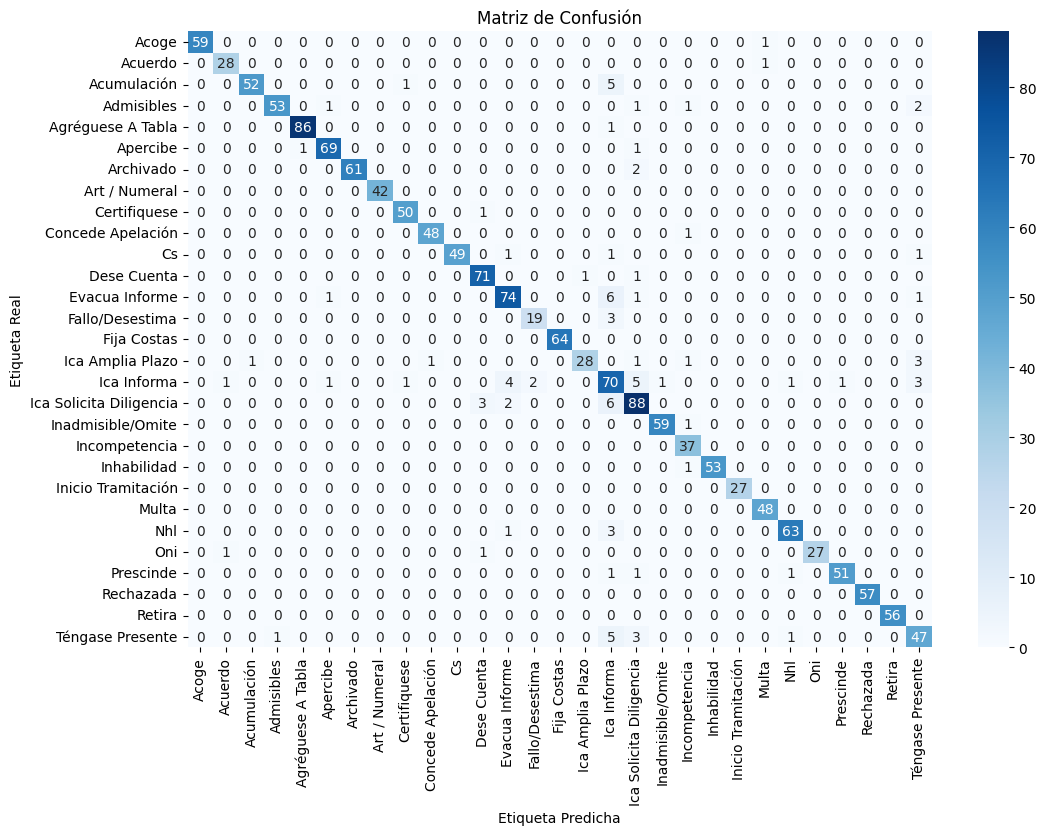

In [47]:
df_smote_3 = metricas_clases(X_test, y_test, model)

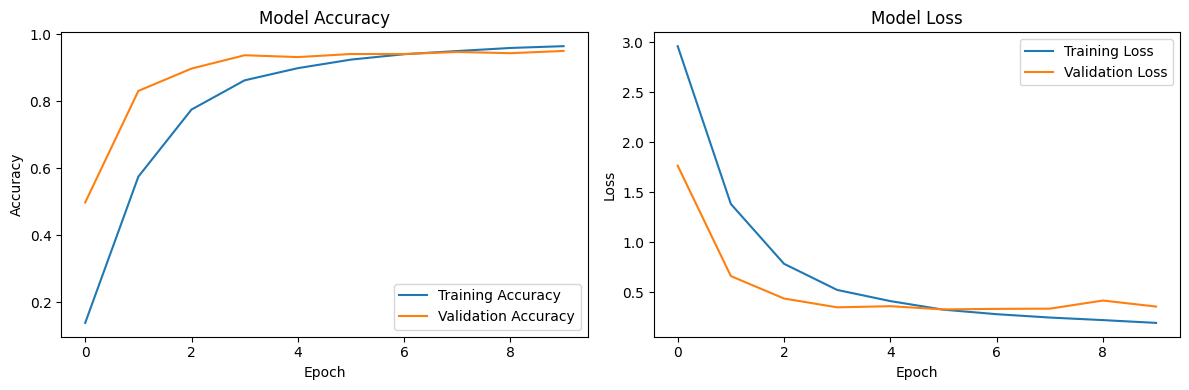

In [48]:
import matplotlib.pyplot as plt

# Graficar la precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Graficar la pérdida
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [49]:
# Nuevo texto para probar
new_description = "Solicita informe a la SUSESO"

# Limpieza (usa la misma función que creaste anteriormente)
cleaned_description = cleaning_data(new_description)

words = cleaned_description.split()
filtered_words = [word for word in words if word.lower() not in stop_words_es]
cleaned_no_stop = ' '.join(filtered_words)
print(cleaned_no_stop)

# Tokenización del texto
tokenized_description = tokenizer.texts_to_sequences([cleaned_no_stop])

# Padding para que tenga la misma longitud que las secuencias de entrenamiento
padded_description = pad_sequences(tokenized_description, maxlen=max_sequence_len, padding='pre')
# Realizar la predicción
prediction = model.predict(padded_description)

# Ordenar las probabilidades de mayor a menor y obtener los índices de las 3 clases más probables
top_3_indices = prediction[0].argsort()[-3:][::-1]

# Mapear índices a etiquetas originales
top_3_labels = label_encoder.inverse_transform(top_3_indices)

# Obtener las probabilidades correspondientes
top_3_probabilities = prediction[0][top_3_indices]
print("Top 3 predicciones más probables:")
for i in range(3):
    print(f"{i+1}. Clase: {top_3_labels[i]} - Probabilidad: {top_3_probabilities[i]:.2f}")


solicita informe suseso
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
Top 3 predicciones más probables:
1. Clase: Ica Solicita Diligencia - Probabilidad: 0.61
2. Clase: Ica Informa - Probabilidad: 0.16
3. Clase: Dese Cuenta - Probabilidad: 0.12


### **BALANCEO DE CLASES**

##### **Cambios**

- Regularización más fuerte
- Agregada una capa bidireccional en la capa LSTM bajando la cantidad de neuronas
- Dejando sola 1 capa densa de 32 neuronas
- Incluyendo batch normalization
- Cambiando el optimizer por Nadam

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Definición del modelo
model = Sequential()

# Capa de Embedding
model.add(Embedding(input_dim=total_words, output_dim=128, input_length=max_sequence_len))

# Capa LSTM Bidireccional
model.add(Bidirectional(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.0005))))
model.add(Dropout(0.4))

# Capa densa
model.add(Dense(12, activation='relu', kernel_regularizer=l2(0.0005)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Capa de salida
model.add(Dense(y_categorical.shape[1], activation='softmax'))

# Compilación del modelo
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

c:\DEEP_LEARNING\Project_1\myenv\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [51]:
y_train_int = y_train.argmax(axis=1)  # De one-hot a entero
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_int), y=y_train_int)

class_weights_dict = dict(enumerate(class_weights))
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=10, batch_size=32, 
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.2103 - loss: 3.0432 - val_accuracy: 0.7996 - val_loss: 2.8299 - learning_rate: 0.0010
Epoch 2/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.7126 - loss: 1.4621 - val_accuracy: 0.9234 - val_loss: 1.1757 - learning_rate: 0.0010
Epoch 3/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8345 - loss: 0.9197 - val_accuracy: 0.9387 - val_loss: 0.5084 - learning_rate: 0.0010
Epoch 4/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8810 - loss: 0.6967 - val_accuracy: 0.9504 - val_loss: 0.3703 - learning_rate: 0.0010
Epoch 5/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8949 - loss: 0.5502 - val_accuracy: 0.9406 - val_loss: 0.3291 - learning_rate: 0.0010
Epoch 6/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9059 - loss: 0.4568 - val_accuracy: 0.9449 - val_loss: 0.2991 - learning_rate: 0.0010
Epoch 7/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9139 - loss: 0.

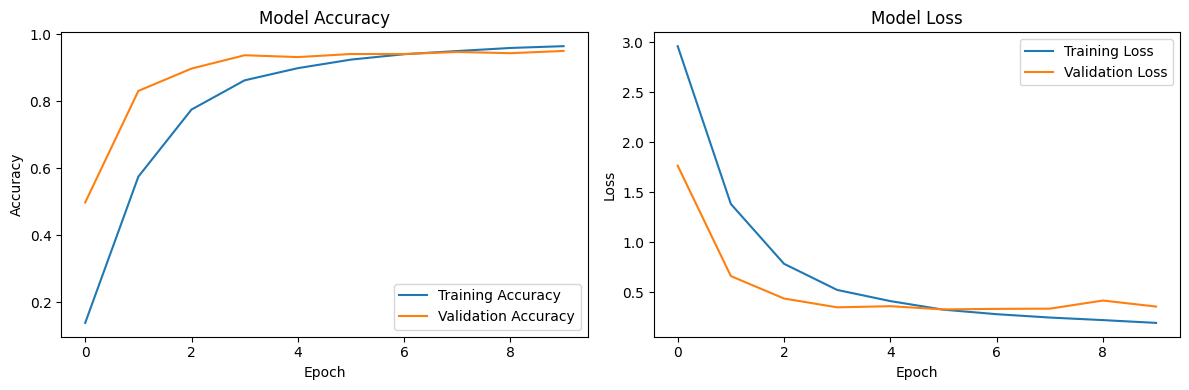

In [52]:
import matplotlib.pyplot as plt

# Graficar la precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Graficar la pérdida
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Informe de clasificación:
                         precision    recall  f1-score   support

                  Acoge       0.97      0.98      0.98        60
                Acuerdo       0.94      1.00      0.97        29
            Acumulación       0.98      0.88      0.93        58
             Admisibles       0.96      0.90      0.93        58
      Agréguese A Tabla       0.99      1.00      0.99        87
               Apercibe       0.96      0.97      0.97        71
              Archivado       0.98      0.95      0.97        63
          Art / Numeral       0.98      1.00      0.99        42
           Certifiquese       0.93      1.00      0.96        51
      Concede Apelación       0.96      0.98      0.97        49
                     Cs       0.98      0.94      0.96        52
            Dese Cuenta       0.95      0.96      0.95        73
         Evacua Informe       0.92      0.96      0.94        83
        Fallo/Desestima 

c:\DEEP_LEARNING\Project_1\myenv\lib\site-packages\sklearn\metrics\_classification.py:2687: UserWarning: labels size, 28, does not match size of target_names, 29
  warnings.warn(


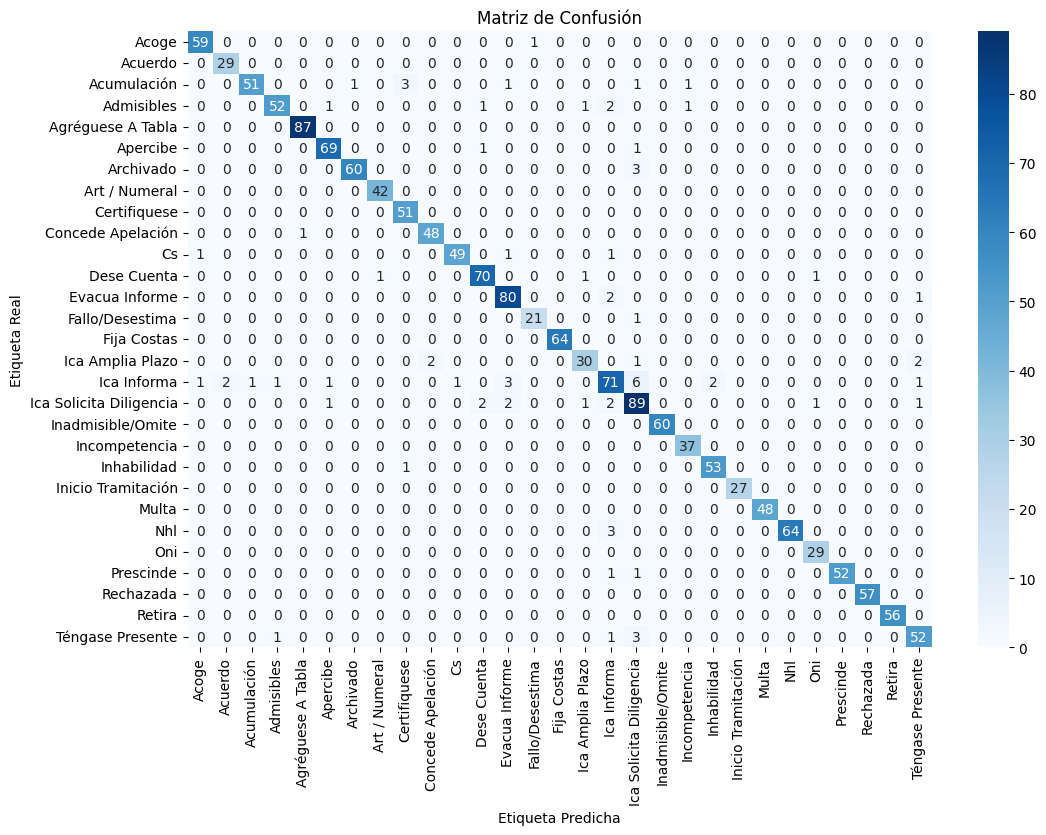

In [53]:
df_balanceweights = metricas_clases(X_test, y_test, model)

In [54]:
asdasda

NameError: name 'asdasda' is not defined

In [59]:
# Guardar modelo
model.save('modelo_final.h5')


In [60]:
import pickle

# Guardar el tokenizer
with open('tokenizer_2.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [61]:
with open('label_encoder_2.pickle', 'wb') as handle:
    pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
history2 = model.fit(
    X_train, 
    y_train,
    epochs=10, 
    batch_size=32, 
    validation_data = (X_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.1178 - loss: 3.1011 - val_accuracy: 0.3435 - val_loss: 2.0698 - learning_rate: 0.0010
Epoch 2/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - accuracy: 0.3868 - loss: 1.9588 - val_accuracy: 0.6804 - val_loss: 1.1106 - learning_rate: 0.0010
Epoch 3/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step - accuracy: 0.6483 - loss: 1.1591 - val_accuracy: 0.8341 - val_loss: 0.6542 - learning_rate: 0.0010
Epoch 4/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.7795 - loss: 0.7868 - val_accuracy: 0.9062 - val_loss: 0.4543 - learning_rate: 0.0010
Epoch 5/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - accuracy: 0.8431 - loss: 0.6211 - val_accuracy: 0.9378 - val_loss: 0.3474 - learning_rate: 0.0010
Epoch 6/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.8839 - loss: 0.4485 - val_accuracy: 0.9423 - val_loss: 0.3192 - learning_rate: 0.0010
Epoch 7/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - accuracy: 0.9083 - l

In [55]:
df_prueba = pd.read_csv('D:/Llanos/BBDD_JSON_EDS.csv')

In [56]:
df_prueba = df_prueba.loc[df_prueba['Trámite'].isin(['Resolución','Sentencia'])]

In [57]:
lista_listas = df_prueba['Descripción'].str.split('//').tolist()
lista_aplanada = [item.strip() for sublista in lista_listas for item in sublista if item.strip()]
lista_unica = list(set(lista_aplanada))
sentences_ = lista_unica

In [58]:
import pandas as pd
import numpy as np

# Supongamos que ya tienes estas variables definidas:
# model, tokenizer, label_encoder, unique_values, max_sequence_len

# Crear un DataFrame para almacenar los resultados
results = []

# Clasificar cada palabra única
for word in sentences_:
    if word.strip() == '':  # Ignorar cadenas vacías
        continue
    
    # Limpieza del texto (si es necesario)
    cleaned_description = cleaning_data(word)
    words = cleaned_description.split()
    filtered_words = [word for word in words if word.lower() not in stop_words_es]
    cleaned_no_stop = ' '.join(filtered_words)
    # Tokenización del texto
    tokenized_word = tokenizer.texts_to_sequences([cleaned_no_stop])
    
    # Padding para que tenga la misma longitud que las secuencias de entrenamiento
    padded_word = pad_sequences(tokenized_word, maxlen=max_sequence_len, padding='pre')
    
    # Realizar la predicción
    prediction = model.predict(padded_word)
    
    # Obtener las 3 clases más probables
    top_3_indices = prediction[0].argsort()[-3:][::-1]
    top_3_labels = label_encoder.inverse_transform(top_3_indices)
    top_3_probabilities = prediction[0][top_3_indices]
    
    # Almacenar los resultados
    results.append({
        'Palabra': word,
        'Clase 1': top_3_labels[0],
        'Probabilidad 1': top_3_probabilities[0],
        'Clase 2': top_3_labels[1],
        'Probabilidad 2': top_3_probabilities[1],
        'Clase 3': top_3_labels[2],
        'Probabilidad 3': top_3_probabilities[2]
    })

# Convertir los resultados a un DataFrame
results_df = pd.DataFrame(results)

# Exportar el DataFrame a un archivo Excel
results_df.to_excel('clasificacion_palabras.xlsx', index=False)

print("Clasificación exportada a 'clasificacion_palabras.xlsx'")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━

In [ ]:
label_encoder.classes_

array(['Acoge', 'Acuerdo', 'Acumulación', 'Admisibles',
       'Agréguese A Tabla', 'Apercibe', 'Archivado', 'Art / Numeral',
       'Certifiquese', 'Concede Apelación', 'Cs', 'Dese Cuenta',
       'Evacua Informe', 'Fallo/Desestima', 'Fija Costas',
       'Ica Amplia Plazo', 'Ica Informa', 'Ica Solicita Diligencia',
       'Inadmisible/Omite', 'Incompetencia', 'Inhabilidad',
       'Inicio Tramitación', 'Multa', 'Nhl', 'Oni', 'Prescinde',
       'Rechazada', 'Retira', 'Téngase Presente'], dtype=object)